In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import numpy  as np
from scipy.stats import norm
import matplotlib.pyplot as plt
# convert evaluation dataset from json to python dictionary
# with open('/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/eval_dataset_threshold.json', 'r') as f:
with open('/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/threshold_eval_dataset.json', 'r') as f:
    data = json.load(f)

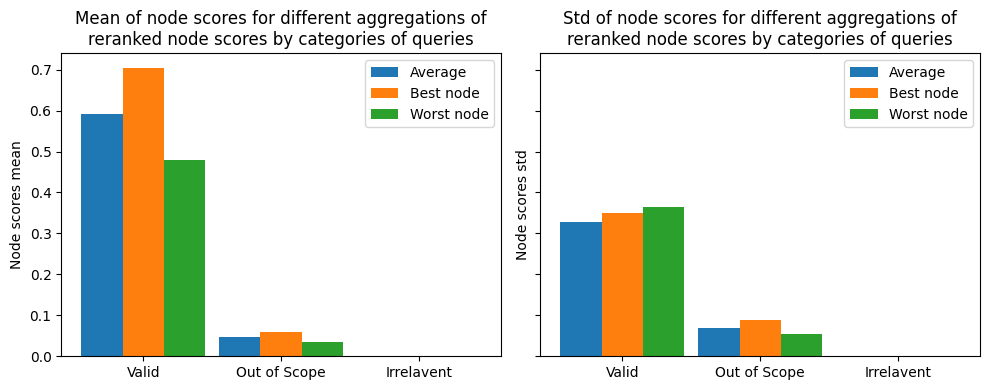

In [ ]:
# scores for average of 2 reranked nodes
scores_1 = []
# scores for best (most relevant) node
scores_2 = []
# scores for worst (most irrelevant) node
scores_3 = []
for d in data:
    s1, s2 = float(d["scores"][0]), float(d["scores"][1])
    scores_1.append(np.around(np.mean([s1, s2]), decimals=4))
    scores_2.append(s1)
    scores_3.append(s2)

# seperate the scores into 3 groups: valid, out of scope, irrelevant
labels = ['Valid', 'Out of Scope', 'Irrelavent']

# plots of mean and std for 3 groups and 3 aggregation
mean_scores_1 = [np.mean(scores_1[:30]), np.mean(scores_1[30:40]), np.mean(scores_1[40:50])]
mean_scores_2 = [np.mean(scores_2[:30]), np.mean(scores_2[30:40]), np.mean(scores_2[40:50])]
mean_scores_3 = [np.mean(scores_3[:30]), np.mean(scores_3[30:40]), np.mean(scores_3[40:50])]

std_scores_1 = [np.std(scores_1[:30]), np.std(scores_1[30:40]), np.std(scores_1[40:50])]
std_scores_2 = [np.std(scores_2[:30]), np.std(scores_2[30:40]), np.std(scores_2[40:50])]
std_scores_3 = [np.std(scores_3[:30]), np.std(scores_3[30:40]), np.mean(scores_3[40:50])]

x = np.arange(len(labels))
# fig, axs = 1 ,2
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True, layout = 'tight')
axs[0].bar(x,  mean_scores_1, width=0.3, label="Average")
axs[0].bar(x+0.3,  mean_scores_2, width=0.3, label="Best node", tick_label=labels)
axs[0].bar(x+0.6,  mean_scores_3, width=0.3, label="Worst node")
axs[0].set_ylabel('Node scores mean')
axs[0].set_title('Mean of node scores for different aggregations of\nreranked node scores by categories of queries')
axs[0].legend()

axs[1].bar(x,  std_scores_1, width=0.3, label="Average")
axs[1].bar(x+0.3,  std_scores_2, width=0.3, label="Best node", tick_label=labels)
axs[1].bar(x+0.6,  std_scores_3, width=0.3, label="Worst node")
axs[1].set_ylabel('Node scores std')
axs[1].set_title('Std of node scores for different aggregations of\nreranked node scores by categories of queries')
axs[1].legend()

plt.show()

From above plots, we can see that some threshold to filter out questions that are either out of  scope of irrelevant. Also worst node has mean of 0.5 and std 0.35, it means that a lot of second ranked nodes have very low score.

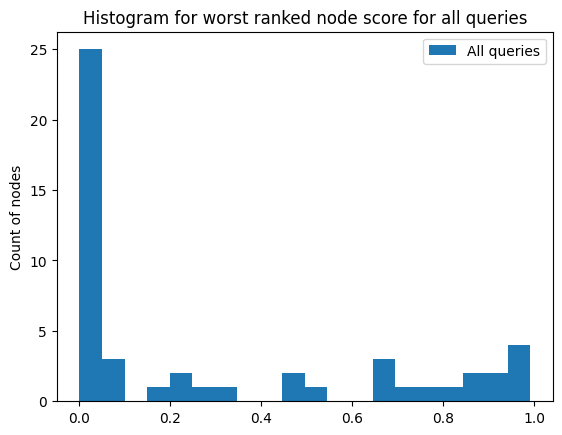

In [ ]:
plt.hist(scores_3, bins=20, label="All queries")
plt.title('Histogram for worst ranked node score for all queries')
plt.ylabel('Count of nodes')
plt.legend()
plt.show()

We can verify the above statement (a lot of second ranked nodes have score close to 0) by plotting scores for all second ranked nodes.

Irrelevant nodes drag the processing speed of whole appication and is a waste of valuable context window. Therefore, we should implement a filter of similarity score of 0.1 after reranking. If there is no node left, VA refuses to answer (no relevant information found => treat as out of scope)

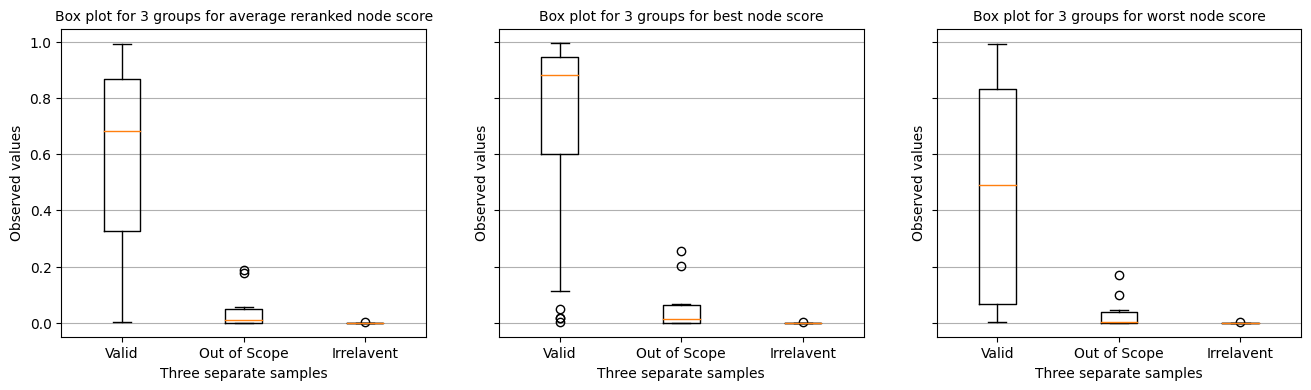

Maximum score of out of scope for best node score: 0.255


In [ ]:
# plot of box and whisker for 3 groups and 3 aggregation
grouped_scores_1 = [scores_1[:30], scores_1[30:40], scores_1[40:50]]
grouped_scores_2 = [scores_2[:30], scores_2[30:40], scores_2[40:50]]
grouped_scores_3 = [scores_3[:30], scores_3[30:40], scores_3[40:50]]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)
fs = 10
axs[0].boxplot(grouped_scores_1, labels=labels)
axs[0].set_title('Box plot for 3 groups for average reranked node score', fontsize=fs)
# axs[0].set_yscale('log')


axs[1].boxplot(grouped_scores_2, labels=labels)
axs[1].set_title('Box plot for 3 groups for best node score', fontsize=fs)
# axs[1].set_yscale('log')

axs[2].boxplot(grouped_scores_3, labels=labels)
axs[2].set_title('Box plot for 3 groups for worst node score', fontsize=fs)
# axs[2].set_yscale('log')

for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

plt.show()
max_score = np.max(grouped_scores_2[1])
print(f"Maximum score of out of scope for best node score: {max_score}")

From above we can try to use 0.255 as threshold to reject out of scope + irrelevant nodes. The threshold is used after reranking to filter out unwanted nodes.

We define a prediction of postive if count of filtered reranked nodes > 0, negative otherwise (=0). We can determine postive if best node has score > threshold. First 30 questions are truely valid and rest of 20 of them irrelevant.

We want to maximize F1 score by adjusting threshold.

F1 score for threshold at 0.2238: 0.8888888888888888


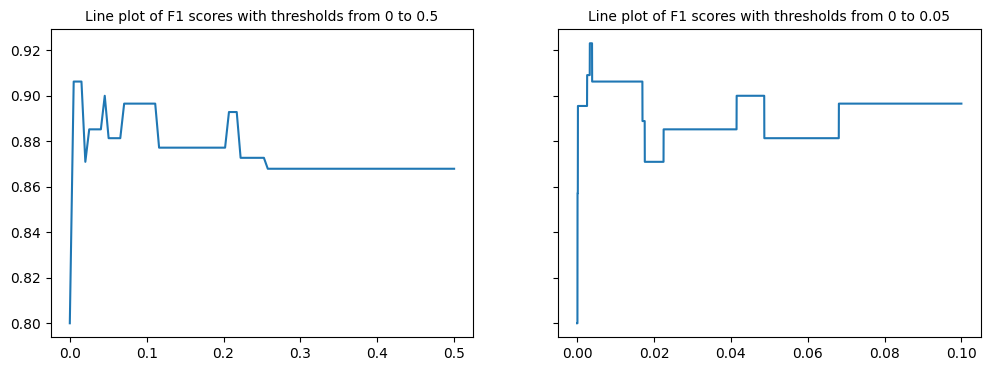

Smallest threshold to reach maximum F1: 0.0033003300330033004
Largest threshold to reach maximum F1: 0.0038903890389038907
At selected threshold, F1: 0.9230769230769229, precision: 1.0, recall: 0.8571428571428571


In [ ]:
def calc_f1_score(data, threshold):
  scores = [float(d["scores"][0]) for d in data]
  temp  = (np.array(scores) > threshold) * 1
  P = temp[:30]
  N = temp[30:]
  TP, TN = sum(P), len(N)-sum(N)
  precision = TP / (len(P))
  recall = TP / (TP + (len(N)-TN))
  F1 = 2 / ((1/precision) + (1/recall))
  return (F1, precision, recall)

# first let's calcualte F1 given a threshold
threshold = max_score
max_score_F1 = calc_f1_score(data, threshold)[0]
print(f"F1 score for threshold at 0.2238: {max_score_F1}")

# to optimise F1 with threshold, we consider a range of threshold around max_score = 0.2238
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
fs = 10

thresholds = np.linspace(0, 0.5, 100)
F1s = [calc_f1_score(data, t)[0] for t in thresholds]
axs[0].plot(thresholds, F1s)
axs[0].set_title('Line plot of F1 scores with thresholds from 0 to 0.5', fontsize=fs)

thresholds = np.linspace(0, 0.1, 10000)
F1s = [calc_f1_score(data, t)[0] for t in thresholds]
axs[1].plot(thresholds, F1s)
axs[1].set_title('Line plot of F1 scores with thresholds from 0 to 0.05', fontsize=fs)

plt.show()

max_F1 = np.max(F1s)
indices = np.where(F1s == max_F1)
print(f"Smallest threshold to reach maximum F1: {thresholds[indices[0][0]]}")
print(f"Largest threshold to reach maximum F1: {thresholds[indices[0][-1]]}")
threshold = 0.0035
F1, precision, recall = calc_f1_score(data, threshold)
print(f"At selected threshold, F1: {F1}, precision: {precision}, recall: {recall}")

To sound more general and natural, I decided to choose 0.0035 as the threshold.

In [ ]:
few_shot_examples =  [
    {
        "input": "What other canteens are available at HKU besides Kiosk by The Sandwich Club?",
        "retrieval_context": [
            "At the moment, this voice assistant only support queries related to 2 canteens, they are Kiosk by The Sandwich Club and BIJAS Vegetarian."
        ],
        "expected_output": "This voice assistant currently only supports queries related to two canteens at HKU - Kiosk by The Sandwich Club and BIJAS Vegetarian."
    },
    {
        "input":  "What types of panini sandwiches does Kiosk by The Sandwich Club offer?",
        "retrieval_context": [
            "Kiosk by The Sandwich Club, Food, Turkey Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food, Pastrami Beef Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food, Mushroom Panini, $33.0, TRUE,",
            "Food, Tuna Fish Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food, Egg Mayonnaise Panini, $33.0, TRUE, \nKiosk by The Sandwich Club, Food, Roasted Chicken Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food,"
        ],
        "expected_output": "Kiosk by The Sandwich Club offers a variety of panini sandwiches including tuna fish, egg mayonnaise, roasted chicken, smoked ham, turkey, pastrami beef, mushroom, and smoked salmon, all priced at $33.0 except for the smoked salmon panini which is $37.0."
    },
    {
        "input": "Does BIJAS Vegetarian offer any beverage options?",
        "retrieval_context": [
            "List of beverage choice: Regular Coffee / Walnut Soya Milk / Daily Special Drink\nBIJAS Vegetarian, Set, Pay By Weight Vegetarian Food, $17.0, TRUE, $17 per 100 grams with minimum purchase $22. Serve with rice and soup\nKiosk by The Sandwich Club, Beverages,",
            "Is_vegan_friendly, Description\nBIJAS Vegetarian, Beverages, Fook Ming Tong Selected Tea, $18.0, TRUE, List of beverage choice: Yunnan Pu Er /jasmine tea /An xi tei guan yin /Zhejiang long jin\nBIJAS Vegetarian, Beverages,"
        ],
        "expected_output": "Yes, BIJAS Vegetarian offers a variety of beverage options, including assorted fresh juice for $27.0, syphon coffee for $42.0, winter melon syrup with pineapple and ginger for $42.0, winter melon syrup with fig leaves and lemon for $42.0, and a lemon drink with perilla and lemongrass for $42.0."
    },
    {
        "input": "What is the location of BIJAS Vegetarian?",
        "retrieval_context": [
            "The restaurant is an equal opportunities employer with half of the staff \nbeing hearing im paired.  \nThe address of BIJAS is G/F Run Run Shaw Tower, Central Podium, Centennial Campus . It is next to \nRun Run Shaw Tower. For opening hours, BIJAS Vegetarian  operates from 11:30 to 21:00 on Monday \nthrough Saturday and public holidays. It is closed on Sunday.",
            "BIJAS Vegetarian  \nThe first vegetarian restaurant in the university headed by the former executive chef of Harvester, \nBijas offers pay -by-weight buffet -style meals in line with the food wise concept. Besides, it offers a \ngreen dining environment where chandeliers are made w ith wasted plastic bottles, wall panels \ntimber with FSC (Forest Stewardship Council) certificate, and bamboo flooring infused with carbon \npowder for air purification. The restaurant is an equal opportunities employer with half of the staff \nbeing hearing im paired."
        ],
        "expected_output": "BIJAS Vegetarian is located at G/F Run Run Shaw Tower, Central Podium, Centennial Campus, next to the Run Run Shaw Tower."
    },
    {
        "input": "I only have $16 to spend. What beverage options do you recommend at BIJAS Vegetarian?",
        "retrieval_context": [
            "List of beverage choice: Regular Coffee / Walnut Soya Milk / Daily Special Drink\nBIJAS Vegetarian, Set, Pay By Weight Vegetarian Food, $17.0, TRUE, $17 per 100 grams with minimum purchase $22. Serve with rice and soup\nKiosk by The Sandwich Club, Beverages,",
            "Is_vegan_friendly, Description\nBIJAS Vegetarian, Beverages, Fook Ming Tong Selected Tea, $18.0, TRUE, List of beverage choice: Yunnan Pu Er /jasmine tea /An xi tei guan yin /Zhejiang long jin\nBIJAS Vegetarian, Beverages,"
        ],
        "expected_output": "Given your budget of $16.0, the best beverage option I can recommend from BIJAS Vegetarian is their walnut soymilk for $13.0. Other beverages all cost more than $16.0"
    },
    {
        "input": "I'm in the mood for something savory and filling. What would you suggest I order from the BIJAS Vegetarian menu?",
        "retrieval_context": [
            "Beverages, Lemon Drink With Perilla And Lemongrass , $42.0, TRUE, \nBIJAS Vegetarian, Food, Noodles With Beancurd In Bakkut Teh , $29.0, TRUE, Noodles can be swapped to Rice Noodles or Rice for free\nBIJAS Vegetarian, Food,",
            "BIJAS Vegetarian, Beverages, Syphon Coffee , $42.0, TRUE, \nBIJAS Vegetarian, Beverages, Winter Melon Syrup With Pineapple And Ginger , $42.0, TRUE, \nBIJAS Vegetarian, Beverages, Winter Melon Syrup With Fig Leaves And Lemon ,"
        ],
        "expected_output": "For a savory and filling meal at BIJAS Vegetarian, I would recommend trying their vegetable dumplings for $29.0. The dumplings, served with noodles is a hearty and satisfying option."
    },
    {
        "input": "I'm in the mood for a nice fish dish. What would you recommend from BIJAS Vegetarian?",
        "retrieval_context": [
            "BIJAS Vegetarian  \nThe first vegetarian restaurant in the university headed by the former executive chef of Harvester, \nBijas offers pay -by-weight buffet -style meals in line with the food wise concept. Besides, it offers a \ngreen dining environment where chandeliers are made w ith wasted plastic bottles, wall panels \ntimber with FSC (Forest Stewardship Council) certificate, and bamboo flooring infused with carbon \npowder for air purification. The restaurant is an equal opportunities employer with half of the staff \nbeing hearing im paired.",
            "$42.0, TRUE, \nBIJAS Vegetarian, Beverages, Winter Melon Syrup With Fig Leaves And Lemon , $42.0, TRUE, \nBIJAS Vegetarian, Beverages, Lemon Drink With Perilla And Lemongrass , $42.0, TRUE, \nBIJAS Vegetarian, Food,"
        ],
        "expected_output": "Unfortunately, BIJAS Vegetarian as a vegetarian restaurant does not appear to offer any fish dishes. Their menu focuses on plant-based options."
    },
    {
        "input": "Can you suggest a meal of beef for me?",
        "retrieval_context": [
            "Beef, Chicken steak, Pork Fillet with Rice /Spaghetti. Optional to add hot drink or soup for $6.5. Optional to add cold drinks for $7.5\nKiosk by The Sandwich Club, Set, Hot Dog Set, $24.0, FALSE, Included hot drink or soup\nKiosk by The Sandwich Club, Set, Breakfast Set A Croissant, $21.0, TRUE, Included hot drink.",
            "Food, Tuna Fish Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food, Egg Mayonnaise Panini, $33.0, TRUE, \nKiosk by The Sandwich Club, Food, Roasted Chicken Panini, $33.0, FALSE, \nKiosk by The Sandwich Club, Food,"
        ],
        "expected_output": "For a meal of beef, I would recommend the pastrami beef paninni. It contains toast with beef and beef pastrami."
    }
]
with open("./few_shot_examples.json", "w") as f:
  json.dump(few_shot_examples, f)

In [ ]:
import requests
from google.colab import userdata
API_TOKEN = userdata.get('HF_token')
import re

# instruction template to extract statements given a passage
instruction = """You are a judge for evaluating some LLM application performance. \
You will be given a message and your task is to extract one or more statements in the message. \
Then, you will output each of the extracted statement on a new line. \
Here are some examples:

Message: No, the Smoked Salmon Panini is not vegan friendly as it contains smoked salmon, which is an animal product.
Statements:
The Smoked Salmon Panini is not vegan friendly.
The Smoked Salmon Panini contains smoked salmon, which is an animal product.

Message: """

question_generation_instruction = f"""You are given an answer for a question. You want to generate some questions for the given answer to guess the original answer.
Answer: """
headers = {"Authorization": f"Bearer {API_TOKEN}"}
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"

# function to call API of LLM to perform statement extraction
def query(input):
  input = "<s>[INST] " + instruction + input + "\nStatements: [/INST] "
  # print(input)
  payload = {
    "inputs": input,
    "parameters": {
    "return_full_text": False,
    "max_new_tokens": 512
    },
    "options": {
        "use_cache": True,
        "wait_for_model": True
    }}
  response = requests.post(API_URL, headers=headers, json=payload)
  return response.json()

# function to call API of LLM to generate n questions for answer relevancy
def generate_questions(input, n):
  input = f"""<s>[INST]You are given an answer for a question. You want to generate {n} questions for the given answer to guess the original answer.
  You should not generate any multiple choice answer for the question. You should only generate {n} questions.

  Answer: Yes, I would suggest you to buy hot black coffee for $19.0 at the sandwich club.
  Question 1: Where can I buy hot black coffee?
  Question 2: Can you suggest a place for me to buy hot black coffee?
  Question 3: How much is a hot black coffee in the sandwich club?

  Answer: {input}
  Question 1: [/INST]"""
  # print(input)
  payload = {
    "inputs": input,
    "parameters": {
    "return_full_text": False,
    "max_new_tokens": 256
    },
    "options": {
        "use_cache": True,
        "wait_for_model": True
    }}
  response = requests.post(API_URL, headers=headers, json=payload)
  return response.json()

# use regex to extract text of statements, as the LLM keep generating prefix like 1. 2. after I change several promptings.
def get_statements(response):
  text = response[0]["generated_text"].split("\n\n", 1)[0] # remove trailing irrelevant generation
  pattern = r'^\d+\.\s*(.*)'
  statements = re.findall(pattern, text, re.MULTILINE)
  if len(statements) == 0: # if the pattern is not found, just put whole text as one statement
    statements = [text]
  return statements

def get_questions(response):
  response = "Question 1: " + response[0]["generated_text"].strip().split("\n\n", 1)[0]
  questions = [question[question.find(":")+2:] for question in response.split("\n")]
  return questions

In [ ]:
# Generate statements from eval dataset for zero show, few shot for later automatic evaluation
# ignore irrelavant and out of scope as they are not intended to be answered

with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/zero_shot_eval_dataset.json", "r") as f:
# with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/few_shot_eval_dataset.json", "r") as f:
  data = json.load(f)

for idx, row in enumerate(data):
  if idx < 30:
    print(idx+1)
    answer = row["actual_output"]
    response = query(answer)
    statements = get_statements(response)
    row["actual_output_statements"] = statements

    ground_truth = row["expected_output"]
    response = query(ground_truth)
    statements = get_statements(response)
    row["ground_truth_statements"] = statements

    context = " ".join(row["retrieval_context"])
    response = query(context)
    statements = get_statements(response)
    row["context_statements"] = statements

    # generate 3 questions for answer relevancy evaluation
    response = generate_questions(answer, 3)
    row["generated_questions"] = get_questions(response)
  else:
    row["actual_output_statements"] = []
    row["ground_truth_statements"] = []
    row["context_statements"] = []
    row["generated_questions"] = []


with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/zero_shot_eval_dataset_with_statements.json", "w") as f:
# with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/few_shot_eval_dataset_with_statements.json", "w") as f:
  json.dump(data, f)

In [ ]:
from google.colab import output
# Load each statements to see if they are alright, edit manually if needed
# with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/zero_shot_eval_dataset_with_statements.json", "r") as f:
with open("/content/drive/MyDrive/Colab Notebooks/FYP_Eval/Dataset/few_shot_eval_dataset_with_statements.json", "r") as f:
  data = json.load(f)

for idx, row in enumerate(data):
  # statements = row["actual_output_statements"]
  # statements = row["ground_truth_statements"]
  # statements = row["context_statements"]
  statements = row["generated_questions"]
  for statement in statements:
    print(statement)
  _ = input(f"\n\nYour are currently looking at {idx+1}th row, press enter if you finish inspecting this row: ")
  output.clear()